# Approach Detection Model

## Import libraries and load model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pathlib # for reading files

# Load the model
model = tf.keras.models.load_model('models/model_approach.h5')

# Display the model
model.summary()

## Visualizing Filters

In [ ]:
# Get the weights of the first convolutional layer
first_conv_layer = model.get_layer('conv2d')  # Adjust the index based on your model
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to [0, 1] for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the filters
n_filters = filters.shape[-1]
plt.figure(figsize=(8, 8))
for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(4, 4, i + 1)  # Adjust dimensions based on the number of filters
    plt.imshow(f[:, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


It seems that this layer is focusing more on light and dark patterns.

## Visualizing Feature maps
Feature maps are the result of applying filters to the input image. They highlight the parts of the image that the filters respond to.

In [ ]:
data_dir = pathlib.Path('C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\cats_approach_training_2024_05_19\\categories')
batch_size = 32
#Larger batches also provide a more accurate estimate of the gradient, but they require more memory.

img_height = 180 # Using the actual sizes takes too long for training.
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
from tensorflow.keras.models import Model

# Create a new model that outputs the feature maps of the first conv layer
feature_map_model = Model(inputs=model.inputs, outputs=model.get_layer('conv2d').output)

# Select an image from the dataset
for images, _ in train_ds.take(1):
    img = images[0:1]

# Get the feature maps
feature_maps = feature_map_model.predict(img)

# Plot the feature maps
n_features = feature_maps.shape[-1]
plt.figure(figsize=(8, 8))
for i in range(n_features):
    plt.subplot(4, 4, i + 1)  # Adjust dimensions based on the number of feature maps
    plt.imshow(feature_maps[0, :, :, i], cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Get the weights of the first convolutional layer
first_conv_layer = model.get_layer('conv2d')
filters, biases = first_conv_layer.get_weights()

# Normalize filter values to [0, 1] for visualization
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[-1]  # Number of filters
n_channels = filters.shape[-2]  # Number of channels in each filter

# Plot the filters
plt.figure(figsize=(8, 8))
for i in range(n_filters):
    for j in range(n_channels):
        ax = plt.subplot(n_filters, n_channels, i * n_channels + j + 1)
        plt.imshow(filters[:, :, j, i], cmap='viridis')
        plt.axis('off')
plt.show()


each column respresents one of the three color channels for each filter

## Grad-CAM Heatmap
Grad-CAM (Gradient-weighted Class Activation Mapping) provides a visual explanation for predictions made by the model. It highlights regions in the image that are important for the prediction.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Function to load and preprocess the image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM heatmap on image
def display_gradcam(img_path, heatmap, alpha=0.4, ax=None):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    if ax:
        ax.imshow(superimposed_img)
        ax.axis('off')
    else:
        plt.imshow(superimposed_img)
        plt.axis('off')
        plt.show()

# Paths to example images of different classes
img_paths = [
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_06_11_02_37_936652_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_07_01_57_14_593121_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_06_17_24_36_433898_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_08_04_58_49_309894_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_08_04_58_49_309894_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_09_04_53_08_223964_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_07_16_47_17_735764_cat.jpg',
    'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_y\\2024_06_09_03_35_08_856693_cat.jpg'
]

# Size of images expected by the model
img_size = (180, 180)

# Layer name of the last convolutional layer
last_conv_layer_name = "conv2d_2"  # Update the layer name based on your model

# Plotting the Grad-CAM for each image in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, img_path in enumerate(img_paths):
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)
    display_gradcam(img_path, heatmap, alpha=0.4, ax=axes[i])
plt.tight_layout()
plt.show()


The model seems to focus too much on the background, i.e., the veranda. One solution would be to crop the images in the previous step to the "cat area". Or just more training data to induce more variability in the backgrounds.

## LIME
Local Interpretable Model-agnostic Explanations

In [ ]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image


print('Notebook run using keras:', keras.__version__)

In [ ]:
# Load model
model = tf.keras.models.load_model('models/model_approach.h5')

In [ ]:
# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_approach_n\\2024_06_07_01_57_12_963533_cat.jpg'
img_height = 180
img_width = 180

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)

print(predictions[0][0])

# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title('Approaching Score: {:.2f}'.format(predictions[0][0]))

This cat is obviously not approaching, but the model classifies it as approaching for with  52% confidence

In [ ]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()


In [ ]:
# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)


In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

Yeah we need to crop the image. It get's too much confusion from the background

# Cat Classification

Notebook run using keras: 2.10.0
1/1 [==============================] - 0s 40ms/step
[ 0.47466406  0.29648685 -0.87443393]
tf.Tensor([0.47703815 0.39918274 0.1237791 ], shape=(3,), dtype=float32)
This image most likely belongs to Hali with a 47.70 percent confidence.


Text(0.5, 1.0, 'Most likely Hali with a 47.70 % confidence.')

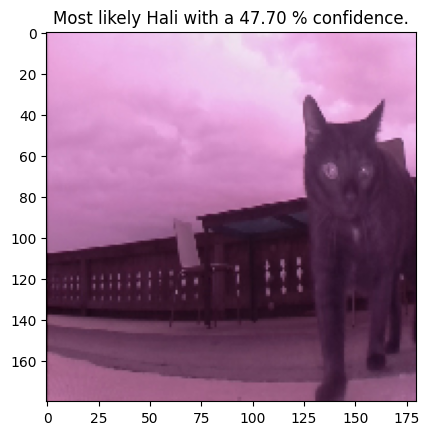

In [73]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

# Load model
model = tf.keras.models.load_model('models/model_hrs6.h5')

# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\test_h\\2024_06_08_21_25_13_832330_cat.jpg'
img_height = 180
img_width = 180
class_names = ['Hali', 'Rex', 'Simba']

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)
print(predictions[0])
score = tf.nn.softmax(predictions[0])
print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title("Most likely {} with a {:.2f} % confidence"
    .format(class_names[np.argmax(score)], 100 * np.max(score)))


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  3%|▎         | 28/1000 [00:00<00:03, 278.54it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 56/1000 [00:00<00:03, 238.09it/s]

1/1 [==============================] - 0s 13ms/step


  8%|▊         | 81/1000 [00:00<00:04, 217.63it/s]

1/1 [==============================] - 0s 12ms/step


 11%|█         | 110/1000 [00:00<00:04, 221.29it/s]

1/1 [==============================] - 0s 12ms/step


 14%|█▍        | 140/1000 [00:00<00:03, 227.88it/s]

1/1 [==============================] - 0s 11ms/step


 16%|█▋        | 163/1000 [00:00<00:03, 228.16it/s]

1/1 [==============================] - 0s 12ms/step


 19%|█▉        | 190/1000 [00:00<00:03, 223.15it/s]

1/1 [==============================] - 0s 12ms/step


 22%|██▏       | 220/1000 [00:00<00:03, 225.68it/s]

1/1 [==============================] - 0s 12ms/step


 25%|██▌       | 250/1000 [00:01<00:03, 225.57it/s]

1/1 [==============================] - 0s 12ms/step


 28%|██▊       | 280/1000 [00:01<00:03, 226.33it/s]

1/1 [==============================] - 0s 12ms/step


 31%|███       | 310/1000 [00:01<00:03, 225.52it/s]

1/1 [==============================] - 0s 12ms/step


 34%|███▍      | 340/1000 [00:01<00:02, 224.96it/s]

1/1 [==============================] - 0s 12ms/step


 37%|███▋      | 370/1000 [00:01<00:02, 225.37it/s]

1/1 [==============================] - 0s 11ms/step


 40%|████      | 400/1000 [00:01<00:02, 226.96it/s]

1/1 [==============================] - 0s 11ms/step


 43%|████▎     | 430/1000 [00:01<00:02, 225.78it/s]

1/1 [==============================] - 0s 12ms/step


 46%|████▌     | 460/1000 [00:02<00:02, 227.99it/s]

1/1 [==============================] - 0s 12ms/step


 48%|████▊     | 483/1000 [00:02<00:02, 226.23it/s]

1/1 [==============================] - 0s 12ms/step


 51%|█████     | 510/1000 [00:02<00:02, 219.35it/s]

1/1 [==============================] - 0s 12ms/step


 54%|█████▍    | 540/1000 [00:02<00:02, 219.72it/s]

1/1 [==============================] - 0s 11ms/step


 57%|█████▋    | 570/1000 [00:02<00:01, 220.96it/s]

1/1 [==============================] - 0s 12ms/step


 60%|██████    | 600/1000 [00:02<00:01, 223.82it/s]

1/1 [==============================] - 0s 12ms/step


 63%|██████▎   | 630/1000 [00:02<00:01, 226.15it/s]

1/1 [==============================] - 0s 12ms/step


 66%|██████▌   | 660/1000 [00:02<00:01, 226.75it/s]

1/1 [==============================] - 0s 12ms/step


 69%|██████▉   | 690/1000 [00:03<00:01, 227.64it/s]

1/1 [==============================] - 0s 11ms/step


 72%|███████▏  | 718/1000 [00:03<00:01, 240.50it/s]

1/1 [==============================] - 0s 12ms/step


 74%|███████▍  | 743/1000 [00:03<00:01, 227.59it/s]

1/1 [==============================] - 0s 12ms/step


 77%|███████▋  | 770/1000 [00:03<00:01, 220.83it/s]

1/1 [==============================] - 0s 12ms/step


 80%|███████▉  | 795/1000 [00:03<00:00, 228.26it/s]

1/1 [==============================] - 0s 12ms/step


 82%|████████▏ | 820/1000 [00:03<00:00, 215.99it/s]

1/1 [==============================] - 0s 12ms/step


 85%|████████▌ | 850/1000 [00:03<00:00, 218.79it/s]

1/1 [==============================] - 0s 13ms/step


 88%|████████▊ | 880/1000 [00:03<00:00, 222.15it/s]

1/1 [==============================] - 0s 12ms/step


 91%|█████████ | 910/1000 [00:04<00:00, 222.55it/s]

1/1 [==============================] - 0s 11ms/step


 94%|█████████▍| 940/1000 [00:04<00:00, 225.02it/s]

1/1 [==============================] - 0s 12ms/step


 97%|█████████▋| 970/1000 [00:04<00:00, 225.70it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 1000/1000 [00:04<00:00, 225.24it/s]


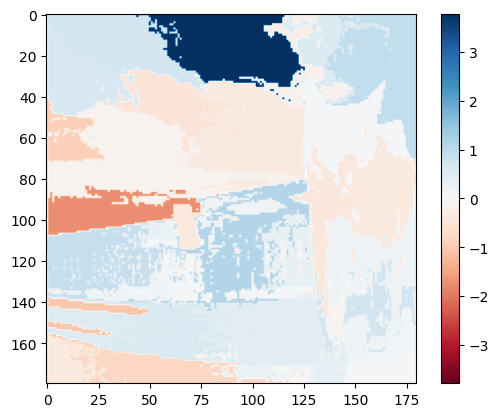

In [74]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)


#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# Prey Detection: LIME

In [ ]:
import os
import tensorflow as tf
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from skimage.segmentation import mark_boundaries
from lime import lime_image

print('Notebook run using keras:', keras.__version__)

In [ ]:
# Load model
model = tf.keras.models.load_model('models/model_prey.h5')

In [ ]:
# Path to the image to explain
img_path = 'C:\\Users\\mirela\\Documents\\gitRepos\\CatWatcher\\examples\\2024_05_17_09_34_57_586252_cat_mouth_detected.jpg'
img_height = 480
img_width = 480

img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))

# Preprocess the image
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# get predictions
predictions = model.predict(img_array)

print(predictions[0][0])

# display the image
plt.imshow(img)

# display the image with Approaching Score: predictions[0][0] (rounded to 2 decimals) as title
plt.title('Prey Score: {:.2f}'.format(predictions[0][0]))

In [ ]:
# Define the prediction function
def predict(images):
    return model.predict(images)

# Instantiate LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation
explanation = explainer.explain_instance(img_array[0].numpy().astype('double'), 
                                         predict, hide_color=0, num_samples=1000)

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()